How weather is impacting the electricity demand in Victoria?
1.	Check if there is a correlation between Max temperature and Electricity demand for CITIPOWER distributor.
H1 : When Max temperature is > T_Median electricity demand is > D_Median
H0 : No such relationship

2.	Do the similar analysis for Rain and Solar

In [616]:
import pandas as pd
import datetime
import glob
import calendar
import matplotlib.pyplot as plt
import scipy.stats as st

In [617]:
def refactor_weather_data(bomDF,year):    
    dateslist = pd.date_range(start=f'1/1/{year}', end=f'31/12/{year}')
    weatherlist  = bomDF['Jan'].tolist()
    if calendar.isleap(year):
        weatherlist = weatherlist + bomDF['Feb'].tolist()[0:29]
    else:
        weatherlist = weatherlist + bomDF['Feb'].tolist()[0:28]          
    weatherlist = weatherlist + bomDF['Mar'].tolist() + bomDF['Apr'].tolist()[0:30] + bomDF['May'].tolist() + bomDF['Jun'].tolist()[0:30] + bomDF['Jul'].tolist() + bomDF['Aug'].tolist() + bomDF['Sep'].tolist()[0:30] + bomDF['Oct'].tolist() + bomDF['Nov'].tolist()[0:30] + bomDF['Dec'].tolist()

    weatherDF = pd.DataFrame({'Date': dateslist, 'Measure': weatherlist})
    return weatherDF


In [618]:

dir = 'BOM/Resources/Weather/_*.csv'
files = glob.glob(dir)
weatherDF = pd.DataFrame()
for f in files:
    filenamelist = f.split("_")
    df = refactor_weather_data(pd.read_csv(f),int(filenamelist[2]))
    df['Distributor'] = filenamelist[1] 
    if filenamelist[3] == '122':
        df['MeasurementType'] = 'MaxTemp'
    elif filenamelist[3] == '123':
        df['MeasurementType'] = 'MinTemp'
    elif filenamelist[3] == '136':
        df['MeasurementType'] = 'Rain Fall'
    elif filenamelist[3] == '193':
        df['MeasurementType'] = 'Solar Exposure'          
    weatherDF = weatherDF.append(df,ignore_index=True)
weatherDF.to_csv('BOM/Resources/Weather/weather.csv')

weatherDF["Measure"] = weatherDF['Measure'].apply(cleanWeatherData)
weatherDF = weatherDF.rename(columns={"Date": "Measure_Date"})
weatherDF.tail()
weatherDF['Measure_Date'] =  pd.to_datetime(weatherDF['Measure_Date'], format="%Y/%m/%d")
weatherDF.head()

,Measure_Date,Measure,Distributor,MeasurementType
0,2015-01-01,26.2,AusNet,MaxTemp
1,2015-01-02,32.5,AusNet,MaxTemp
2,2015-01-03,38.9,AusNet,MaxTemp
3,2015-01-04,25.4,AusNet,MaxTemp
4,2015-01-05,27.3,AusNet,MaxTemp


In [619]:
# data cleansing of measure column
def cleanWeatherData(measure):
    para = str(measure)
    res = '0'
    if para == '↓':
        res = '0'
    elif ' days' in para:        
        res = para[:-4]
    else:
        res = para
    return float(res)

In [620]:
# Load the processed demand data from Electricity Demand Analysis 'Meter data/Demand.csv'

demand_df = pd.read_csv('Meter data/Demand.csv')
demand_df['Measure_Date'] =  pd.to_datetime(demand_df['Measure_Date'], format="%Y/%m/%d")
demand_df = demand_df.loc[demand_df.Measure_Date >= '2015-01-01']
demand_df.reset_index(drop=True, inplace=True)
demand_df.head()    

,Measure_Date,Distributor,Daily_Demand,Business_Demand,Non_Business_Demand
0,2015-01-01,CITIPOWER,3640095.729,1554433,2085662
1,2015-01-02,CITIPOWER,5323070.506,2494996,2828074
2,2015-01-03,CITIPOWER,6340175.938,0,6340175
3,2015-01-04,CITIPOWER,4166689.963,0,4166689
4,2015-01-05,CITIPOWER,4692296.654,2360233,2332063


In [621]:
Vicdemand_df = demand_df.groupby(['Measure_Date']).agg({'Daily_Demand': "sum",'Business_Demand': "sum",'Non_Business_Demand': "sum"})
VicdemandDaily_df = pd.DataFrame(Vicdemand_df['Daily_Demand']/1000000)
VicdemandDaily_df = VicdemandDaily_df.rename(columns={"Daily_Demand": "Daily_Demand (GWh)"})
VicdemandDaily_df = VicdemandDaily_df

In [622]:
MaxTempDF = weatherDF.loc[weatherDF.MeasurementType == 'MaxTemp']
MaxTempDF = MaxTempDF.loc[((MaxTempDF.Measure_Date >= '2015-01-01') & (MaxTempDF.Measure_Date < '2019-07-01'))]
MaxTempDF = MaxTempDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})

VicDailyDemand_MaxTemp = VicdemandDaily_df.merge(MaxTempDF, left_index=True, right_index=True)
VicDailyDemand_MaxTemp.dropna(inplace=True)
VicDailyDemand_MaxTemp.head()

,Daily_Demand (GWh),Measure
Measure_Date,,
2015-01-01,28.756751,26.78
2015-01-02,44.726836,38.02
2015-01-03,54.763326,38.82
2015-01-04,31.517862,23.44
2015-01-05,32.255049,25.02


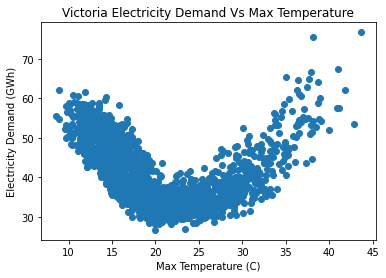

In [623]:

plt.scatter(VicDailyDemand_MaxTemp['Measure'], VicDailyDemand_MaxTemp['Daily_Demand (GWh)'])
plt.xlabel("Max Temperature (C)")
plt.ylabel("Electricity Demand (GWh)")
plt.title("Victoria Electricity Demand Vs Max Temperature")
plt.show()

In [624]:
SolarDF = weatherDF.loc[weatherDF.MeasurementType == 'Solar Exposure']
SolarDF = SolarDF.loc[((SolarDF.Measure_Date >= '2015-01-01') & (SolarDF.Measure_Date < '2019-07-01'))]
SolarDF = SolarDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})

VicDailyDemand_SolarDF = VicdemandDaily_df.merge(SolarDF, left_index=True, right_index=True)
VicDailyDemand_SolarDF.dropna(inplace=True)
VicDailyDemand_SolarDF.head()

,Daily_Demand (GWh),Measure
Measure_Date,,
2015-01-01,28.756751,22.90
2015-01-02,44.726836,28.18
2015-01-03,54.763326,26.16
2015-01-04,31.517862,25.84
2015-01-05,32.255049,28.62


The correlation between both factors is -0.43


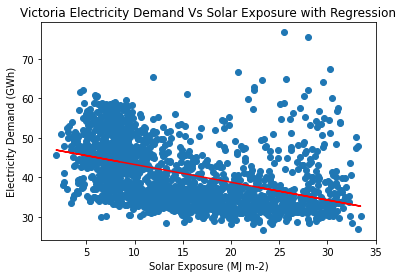

In [625]:
x_values = VicDailyDemand_SolarDF['Measure']
y_values = VicDailyDemand_SolarDF['Daily_Demand (GWh)']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel("Solar Exposure (MJ m-2)")
plt.ylabel("Electricity Demand (GWh)")
plt.title("Victoria Electricity Demand Vs Solar Exposure with Regression")
plt.show()

In [626]:
RainDF = weatherDF.loc[weatherDF.MeasurementType == 'Rain Fall']
RainDF = RainDF.loc[((RainDF.Measure_Date >= '2015-01-01') & (RainDF.Measure_Date < '2019-07-01'))]
RainDF = RainDF.groupby(['Measure_Date']).agg({'Measure': 'mean'})

VicDailyDemand_RainDF = VicdemandDaily_df.merge(RainDF, left_index=True, right_index=True)
VicDailyDemand_RainDF.head()

,Daily_Demand (GWh),Measure
Measure_Date,,
2015-01-01,28.756751,0.00
2015-01-02,44.726836,0.00
2015-01-03,54.763326,0.00
2015-01-04,31.517862,5.52
2015-01-05,32.255049,0.08


The correlation between both factors is 0.04


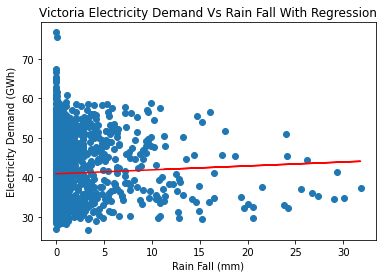

In [627]:
x_values = VicDailyDemand_RainDF['Measure']
y_values = VicDailyDemand_RainDF['Daily_Demand (GWh)']
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel("Rain Fall (mm)")
plt.ylabel("Electricity Demand (GWh)")
plt.title("Victoria Electricity Demand Vs Rain Fall With Regression")
plt.show()